In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import pymysql
import pickle
import json

import numpy as np
from sklearn.decomposition import PCA
import networkx as nx

import os
import umap

import time
import random
import re

import spacy
from gensim.models import Word2Vec

from pmids2vec import pmids2vec
from pmids2corpus import pmids2corpus

from sklearn.cross_decomposition import CCA
import scipy as sp


In [12]:
#path2dir = 'data_processing_feb2020/abstracts_2018_200k/'
path2dir = 'data_processing_feb2020/titles_2018_250k/'
N_samples = 3

In [13]:
### organize list of w2v models

In [20]:
files_list = [f for f in os.listdir(path2dir) if '.model' in f]
w2v_names = []

for i_sample in range(N_samples):
    
    sample_models = [f for f in files_list if '{}_cluster'.format(i_sample) in f]
    N_communities = len(sample_models)
    print("{} communities in sample {}".format(N_communities, i_sample))
    
    w2v_names.append([])
    for i_community in range(N_communities):
        
        for j_path in sample_models:
            if 'cluster{}'.format(i_community) in j_path:
                this_path = j_path
        w2v_names[i_sample].append(this_path)
        print(w2v_names[i_sample][i_community])
    
    print()
    
#  WARNING   assumes communities are matched across samples
#        in number and identity.
#    if this condition does not hold, don't use this analysis

3 communities in sample 0
titles_0_cluster0_2018_250k_titles.model
titles_0_cluster1_2018_250k_titles.model
titles_0_cluster2_2018_250k_titles.model

3 communities in sample 1
titles_1_cluster0_2018_250k_titles.model
titles_1_cluster1_2018_250k_titles.model
titles_1_cluster2_2018_250k_titles.model

3 communities in sample 2
titles_2_cluster0_2018_250k_titles.model
titles_2_cluster1_2018_250k_titles.model
titles_2_cluster2_2018_250k_titles.model



In [ ]:
### helper functions for CCA

In [35]:
def load_model(path2model):
    model = Word2Vec.load(path2model)
    print('{} words '.format(len(model.wv.vocab)))
    return model

In [29]:
def get_shared_vocabulary(modelA, modelB):
    
    vocabA = set(modelA.wv.vocab)
    vocabB = set(modelB.wv.vocab)
    shared_vocab = vocabA.intersection(vocabB)
    shared_vocab = list(shared_vocab)
    
    print("size of shared vocabulary: {}".format(len(shared_vocab)))
    return shared_vocab

In [66]:
def build_sample_matrix(model, vocab_subset, doPlot=True):
    
    D = model.trainables.layer1_size
    samples = np.zeros((len(vocab_subset), D))
    
    for i_word, word in enumerate(vocab_subset):
        samples[i_word,:] = model.wv[word]
        
    # demean
    # todo think more about this
    '''
    for i_word, word in enumerate(shared_vocabulary):
        embedding_samples[i_word,:] -= np.mean(embedding_samples,0)
    
    # normalize all vectors to the hypersphere
    for i_row,row in enumerate(embedding_samples):
        embedding_samples[i_row,:] /= np.linalg.norm(row,2)
    '''
    
    if doPlot:
        min_val = np.min(samples.flatten())
        max_val = np.min(samples.flatten())
        extrema = np.max([abs(min_val), max_val])
        v_min, v_max = -extrema, extrema
        
        plt.figure()
        plt.imshow(samples,
                   origin='lower',
                   extent=[0, D, 0, len(vocab_subset)],
                   aspect= D / len(vocab_subset),
                   vmin = v_min,
                   vmax = v_max,
                   cmap='Spectral')
        plt.colorbar()
        plt.title('sample (original coordinates)')
        plt.xlabel('dimension')
        plt.ylabel('shared word index')
    
    return samples

In [72]:
def run_cca(U, V, N_components=3, doPlot=True):
    
    cca = CCA(n_components=N_components)
    cca.fit(U, V)
    U_c, V_c = cca.transform(U, V)
    cc_corr = np.corrcoef(cca.x_scores_,
                          cca.y_scores_,
                          rowvar=False).diagonal(offset=cca.n_components)
    
    if doPlot:
        plt.figure(figsize=(2,2))
        plt.plot(cc_corr)
        plt.ylim([0,1])
        plt.title('canonical correlations (data)')
        plt.ylabel('correlation coefficient')
        plt.xlabel('canonical component')
        
    return U_c, V_c, cc_corr

In [82]:
def plot_word_similarity(U_c, V_c, shared_vocabulary, doSave=False):
    
    similarities = []
    for i_word, word in enumerate(shared_vocabulary):    
        score = 1 - sp.spatial.distance.cosine(U_c[i_word], V_c[i_word])
        similarities.append(score) 
        
    plt.figure(figsize=(3,3))
    plt.hist(similarities, histtype='step', bins=50, density=True)
    plt.title('aligned word similarities (cosine)')
    plt.xlabel('cosine similarity score (word i in context U vs V)')
    plt.ylabel('probability density')
    
    if doSave:
        plt.savefig(path2dir + 'same_community_cca_wordsimilarities.png')
        plt.savefig(path2dir + 'same_community_cca_wordsimilarities.pdf')
        
    return similarities

In [ ]:
### perform the alignment (same community, different sample)

titles_0_cluster0_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_0_cluster0_2018_250k_titles.model
1530 words 

titles_1_cluster0_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_1_cluster0_2018_250k_titles.model
1523 words 

titles_2_cluster0_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_2_cluster0_2018_250k_titles.model
1497 words 

size of shared vocabulary: 1330
size of shared vocabulary: 1388


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


size of shared vocabulary: 1326
titles_0_cluster1_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_0_cluster1_2018_250k_titles.model
1729 words 

titles_1_cluster1_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_1_cluster1_2018_250k_titles.model
1701 words 

titles_2_cluster1_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_2_cluster1_2018_250k_titles.model
1714 words 

size of shared vocabulary: 1597
size of shared vocabulary: 1601
size of shared vocabulary: 1596
titles_0_cluster2_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_0_cluster2_2018_250k_titles.model
1730 words 

titles_1_cluster2_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_1_cluster2_2018_250k_titles.model
1731 words 

titles_2_cluster2_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_2_cluster2_2018_250k_titles.model
1734 words 

size of shared vocabulary: 1627
size of shared vocabular

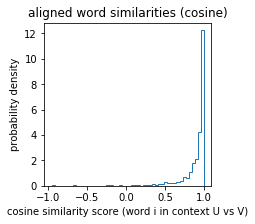

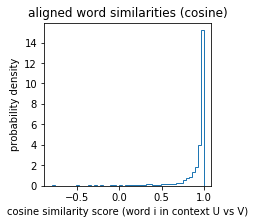

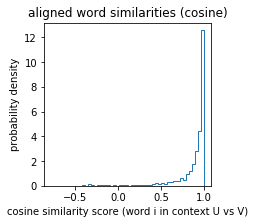

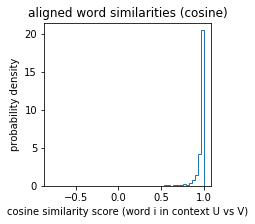

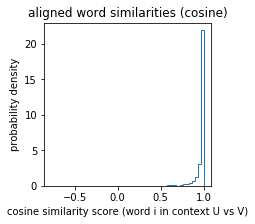

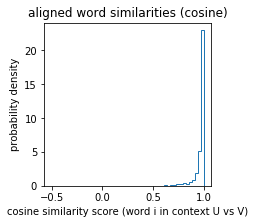

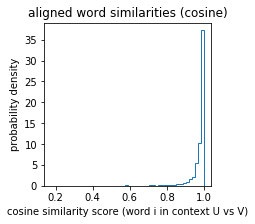

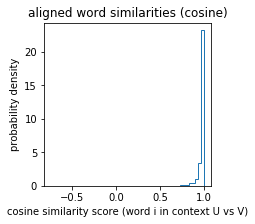

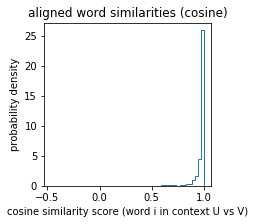

In [86]:
CCA_comparisons = []
for i_community in range(N_communities):
    CCA_comparisons.append([])
    
    # LOAD MODELS
    w2v_models = []  # same community across different samples
    for i_sample in range(N_samples):
        
        print(w2v_names[i_sample][i_community])
        
        path2model = path2dir + w2v_names[i_sample][i_community]
        print(path2model)
        this_model = load_model(path2model)
        w2v_models.append(this_model)
        
        print()
        
    #D = w2v_models[0].trainables.layer1_size  # assume this is matched
    
    # PREPARE COMPARISONS
    i_comparison = 0
    for i_model, modelA in enumerate(w2v_models):
        for j_model, modelB in enumerate(w2v_models):
            
            if i_model < j_model:  # lower triangle only
                
                # book keeping
                CCA_comparisons[i_community].append({})
                CCA_comparisons[i_community][i_comparison]['modelA'] = w2v_names[i_model]
                CCA_comparisons[i_community][i_comparison]['modelB'] = w2v_names[j_model]
                
                # get shared vocabulary
                shared_vocab = get_shared_vocabulary(modelA, modelB)
                CCA_comparisons[i_community][i_comparison]['shared_vocab'] = shared_vocab
                
                # build sample matrices
                samplesA = build_sample_matrix(modelA, shared_vocab, doPlot=False)
                samplesB = build_sample_matrix(modelB, shared_vocab, doPlot=False)

                # align 2 spaces with cca
                (U, V, cc_corr) = run_cca(samplesA,
                                          samplesB,
                                          N_components=3,
                                          doPlot=False)
                
                # save CCA outputs
                CCA_comparisons[i_community][i_comparison]['U'] = U.tolist()
                CCA_comparisons[i_community][i_comparison]['V'] = V.tolist()
                CCA_comparisons[i_community][i_comparison]['cc_corr'] = cc_corr.tolist()
                
                # get & save word similarity distribution
                word_similarities = plot_word_similarity(U, V, shared_vocab, doSave=False)
                CCA_comparisons[i_community][i_comparison]['word_similarities'] = word_similarities
                
                i_comparison += 1

In [84]:
### export results

In [88]:
save_path = path2dir + 'CCA_same_community_comparison.json'
with open(save_path, 'w') as f:
    json.dump(CCA_comparisons, f)

In [ ]:
### perform the alignment (same sample, different communities)

titles_0_cluster0_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_0_cluster0_2018_250k_titles.model
1530 words 

titles_0_cluster1_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_0_cluster1_2018_250k_titles.model
1729 words 

titles_0_cluster2_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_0_cluster2_2018_250k_titles.model
1730 words 

size of shared vocabulary: 683
size of shared vocabulary: 720
size of shared vocabulary: 685
titles_1_cluster0_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_1_cluster0_2018_250k_titles.model
1523 words 

titles_1_cluster1_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_1_cluster1_2018_250k_titles.model
1701 words 

titles_1_cluster2_2018_250k_titles.model
data_processing_feb2020/titles_2018_250k/titles_1_cluster2_2018_250k_titles.model
1731 words 

size of shared vocabulary: 697
size of shared vocabulary: 786
size of shared vocabulary: 67

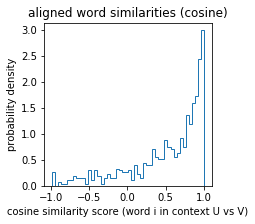

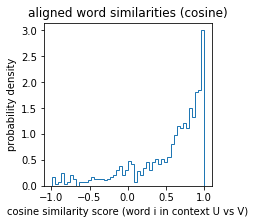

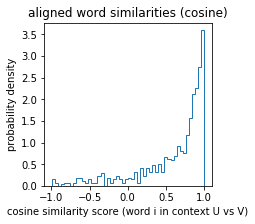

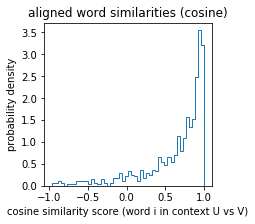

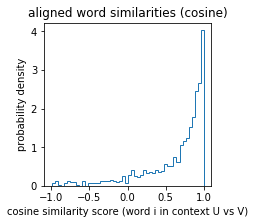

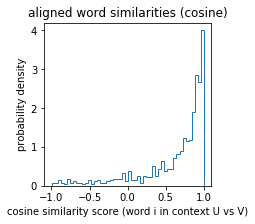

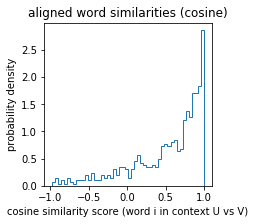

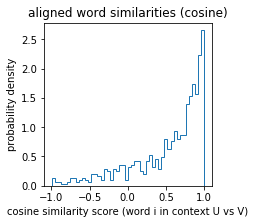

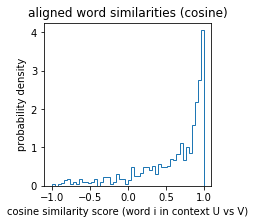

In [89]:
CCA_comparisons = []
for i_sample in range(N_samples):
    CCA_comparisons.append([])
    
    # LOAD MODELS
    w2v_models = []  # same community across different samples
    for i_community in range(N_communities):
        
        print(w2v_names[i_sample][i_community])
        
        path2model = path2dir + w2v_names[i_sample][i_community]
        print(path2model)
        this_model = load_model(path2model)
        w2v_models.append(this_model)
        
        print()
        
    #D = w2v_models[0].trainables.layer1_size  # assume this is matched
    
    # PREPARE COMPARISONS
    i_comparison = 0
    for i_model, modelA in enumerate(w2v_models):
        for j_model, modelB in enumerate(w2v_models):
            
            if i_model < j_model:  # lower triangle only
                
                # book keeping
                CCA_comparisons[i_sample].append({})
                CCA_comparisons[i_sample][i_comparison]['modelA'] = w2v_names[i_model]
                CCA_comparisons[i_sample][i_comparison]['modelB'] = w2v_names[j_model]
                
                # get shared vocabulary
                shared_vocab = get_shared_vocabulary(modelA, modelB)
                CCA_comparisons[i_sample][i_comparison]['shared_vocab'] = shared_vocab
                
                # build sample matrices
                samplesA = build_sample_matrix(modelA, shared_vocab, doPlot=False)
                samplesB = build_sample_matrix(modelB, shared_vocab, doPlot=False)

                # align 2 spaces with cca
                (U, V, cc_corr) = run_cca(samplesA,
                                          samplesB,
                                          N_components=3,
                                          doPlot=False)
                
                # save CCA outputs
                CCA_comparisons[i_sample][i_comparison]['U'] = U.tolist()
                CCA_comparisons[i_sample][i_comparison]['V'] = V.tolist()
                CCA_comparisons[i_sample][i_comparison]['cc_corr'] = cc_corr.tolist()
                
                # get & save word similarity distribution
                word_similarities = plot_word_similarity(U, V, shared_vocab, doSave=False)
                CCA_comparisons[i_sample][i_comparison]['word_similarities'] = word_similarities
                
                i_comparison += 1

In [90]:
save_path = path2dir + 'CCA_cross_community_comparison.json'
with open(save_path, 'w') as f:
    json.dump(CCA_comparisons, f)

In [147]:
### aggregate for plot

load_path = path2dir + 'CCA_cross_community_comparison.json'
with open(load_path, 'r') as f:
    CCA_comparisons = json.load(f)

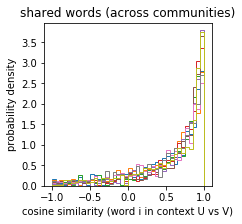

In [148]:
# aggregate cross-cluster word-scores
wordsimilarity_between = []


plt.figure(figsize=(3,3))

for i_sample in range(N_samples):
    
    comparisons = CCA_comparisons[i_sample]
    BINS = np.linspace(-1,1,41)
    for i_comparison, comparison in enumerate(comparisons):
        
        scores = CCA_comparisons[i_sample][i_comparison]['word_similarities']
        plt.hist(scores,
                histtype='step',
                bins=BINS,
                density=True)
        
        wordsimilarity_between = wordsimilarity_between + scores
        
plt.title('shared words (across communities)')
plt.xlabel('cosine similarity (word i in context U vs V)')
plt.ylabel('probability density')

figname = path2dir + 'cca_wordsim_between__juxtapose'
plt.savefig(figname + '.png')
plt.savefig(figname + '.pdf')


In [144]:
### reload the same-community comparison

In [145]:
load_path = path2dir + 'CCA_same_community_comparison.json'
with open(load_path, 'r') as f:
    CCA_comparisons = json.load(f)

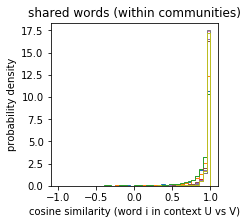

In [146]:
# aggregate cross-cluster word-scores
wordsimilarity_within = []


plt.figure(figsize=(3,3))

for i_sample in range(N_communities):
    
    comparisons = CCA_comparisons[i_sample]
    BINS = np.linspace(-1,1,41)
    for i_comparison, comparison in enumerate(comparisons):
        
        scores = CCA_comparisons[i_sample][i_comparison]['word_similarities']
        plt.hist(scores,
                histtype='step',
                bins=BINS,
                density=True)
        
        wordsimilarity_within = wordsimilarity_within + scores
        
plt.title('shared words (within communities)')
plt.xlabel('cosine similarity (word i in context U vs V)')
plt.ylabel('probability density')

        
figname = path2dir + 'cca_wordsim_within__juxtapose'
plt.savefig(figname + '.png')
plt.savefig(figname + '.pdf')


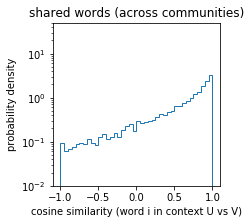

In [149]:
plt.figure(figsize=(3,3))

plt.hist(wordsimilarity_between,
                histtype='step',
                bins=BINS,
                density=True,         
                color='#1f78b4')

plt.title('shared words (across communities)')
plt.xlabel('cosine similarity (word i in context U vs V)')
plt.ylabel('probability density')
plt.yscale('log', nonposy='clip')
plt.ylim([0.01,50])

figname = path2dir + 'cca_wordsim_between__aggregate'
plt.savefig(figname + '.png')
plt.savefig(figname + '.pdf')

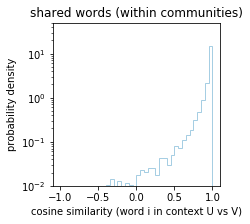

In [150]:
plt.figure(figsize=(3,3))

plt.hist(wordsimilarity_within,
                histtype='step',
                bins=BINS,
                density=True,
                color='#a6cee3')

plt.title('shared words (within communities)')
plt.xlabel('cosine similarity (word i in context U vs V)')
plt.ylabel('probability density')
plt.yscale('log', nonposy='clip')
plt.ylim([0.01,50])

figname = path2dir + 'cca_wordsim_within__aggregate'
plt.savefig(figname + '.png')
plt.savefig(figname + '.pdf')

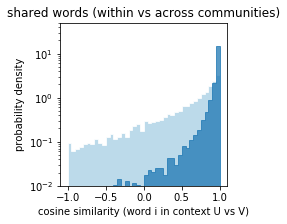

In [203]:
plt.figure(figsize=(3,3))

plt.hist(wordsimilarity_between,
                histtype='stepfilled',
                bins=BINS,
                density=True,    
                edgecolor='#ffffff',
                facecolor='#a6cee3',
                alpha=0.75,
                linewidth=1)

plt.hist(wordsimilarity_within,
                histtype='stepfilled',
                bins=BINS,
                density=True,
                edgecolor='#1f78b4',
                facecolor='#1f78b4',
                alpha=0.75,
                linewidth=1)

plt.title('shared words (within vs across communities)')
plt.xlabel('cosine similarity (word i in context U vs V)')
plt.ylabel('probability density')
plt.yscale('log', nonposy='clip')
plt.ylim([0.01,50])

figname = path2dir + 'cca_wordsim_combined__aggregate'
plt.savefig(figname + '.png')
plt.savefig(figname + '.pdf')


### get large-distance words from each pair

In [ ]:
# plot local w2v neighborhood

In [ ]:
### plot aggregate CCA correlation level plots